<a href="https://colab.research.google.com/github/anmolmann/FinRL-demo/blob/main/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-vfg3uek3
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-vfg3uek3
     |████████████████████████████████| 153kB 9.0MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-gqap2hul/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-gqap2hul/pyfolio
     |████████████████████████████████| 6.3MB 32.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=39024 sha256=095f60f31734aaa6e756739703bc42b0b86841d04a9ff40dfd1c68d067255ebb
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0xjixhc/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=756ad5b50055230195fcdb9871b3bd224183e7b0e96e9dbd9474f9198160e7c8
 

In [ ]:
!pip install tensorflow==1.14.0
!pip install stable-baselines[mpi]==2.10.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL-Library")

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [52]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 5.2MB/s 
     |████████████████████████████████| 133kB 33.3MB/s 
     |████████████████████████████████| 174kB 39.0MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 


In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,5.983694,1079178800,AAPL,2
1,2008-01-02,52.090000,52.320000,50.790001,40.902168,8053700,AXP,2
2,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2
3,2008-01-02,72.559998,72.669998,70.050003,48.153107,6337800,CAT,2
4,2008-01-02,27.000000,27.299999,26.209999,19.706181,64338900,CSCO,2


In [ ]:
df.shape

(98167, 8)

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [ ]:
df.shape

(98167, 12)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30
0,2008-01-02,7.116786,7.152143,6.876786,5.983694,1079178800,AAPL,2,0.0,100.0,-66.666667,100.0
3274,2008-01-02,52.090000,52.320000,50.790001,40.902168,8053700,AXP,2,0.0,100.0,-66.666667,100.0
6548,2008-01-02,87.570000,87.839996,86.000000,63.481632,4303000,BA,2,0.0,100.0,-66.666667,100.0
9822,2008-01-02,72.559998,72.669998,70.050003,48.153107,6337800,CAT,2,0.0,100.0,-66.666667,100.0
13096,2008-01-02,27.000000,27.299999,26.209999,19.706181,64338900,CSCO,2,0.0,100.0,-66.666667,100.0


In [ ]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [ ]:
df.shape

(90660, 13)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,cov_list
0,2008-12-31,3.070357,3.133571,3.047857,2.621168,607541200,AAPL,2,-0.083794,42.254781,-80.495083,16.129793,"[[0.0014139106944709861, 0.0011800737986652427..."
1,2008-12-31,17.969999,18.750000,17.910000,15.064775,9625600,AXP,2,-0.966640,42.554841,-75.355990,25.776759,"[[0.0014139106944709861, 0.0011800737986652427..."
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2,-0.279798,47.440267,156.995097,5.366299,"[[0.0014139106944709861, 0.0011800737986652427..."
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2,0.692236,51.205319,98.438755,26.331746,"[[0.0014139106944709861, 0.0011800737986652427..."
4,2008-12-31,16.180000,16.549999,16.120001,12.102888,37513700,CSCO,2,-0.103446,45.961923,11.969054,13.387087,"[[0.0014139106944709861, 0.0011800737986652427..."


In [ ]:
train = data_split(df, '2009-01-01','2019-01-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [ ]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,cov_list
0,2009-01-02,3.067143,3.251429,3.041429,2.787006,746015200,AAPL,4,-0.071164,45.440193,-32.068804,2.140064,"[[0.0014277088781548904, 0.0011886542010356162..."
0,2009-01-02,18.570000,19.520000,18.400000,15.698216,10955700,AXP,4,-0.859670,43.957529,-42.744390,16.335101,"[[0.0014277088781548904, 0.0011886542010356162..."
0,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,-0.002007,50.822042,272.812831,20.494464,"[[0.0014277088781548904, 0.0011886542010356162..."
0,2009-01-02,44.910000,46.980000,44.709999,32.830360,7117200,CAT,4,0.879728,53.661264,129.786565,34.637448,"[[0.0014277088781548904, 0.0011886542010356162..."
0,2009-01-02,16.410000,17.000000,16.250000,12.592946,40980600,CSCO,4,-0.061991,48.322163,54.503518,2.653808,"[[0.0014277088781548904, 0.0011886542010356162..."


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 30


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [53]:
wandb.init(project="finRL-portfolio-allocation")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# ✨ W&B: Log hyperparameters using config
cfg = wandb.config

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

------------------------------------
| time/                 |          |
|    fps                | 290      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 2.02e+08 |
|    std                | 0.997    |
|    value_loss         | 2.76e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 306      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |
|    policy_loss        | 2.59e+08 |
|

In [ ]:
# Model 2
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

-------------------------------------
| time/                 |           |
|    fps                | 473       |
|    iterations         | 1         |
|    time_elapsed       | 4         |
|    total_timesteps    | 2048      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 12000     |
|    policy_loss        | 5.38e+08  |
|    std                | 0.956     |
|    value_loss         | 1.71e+14  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:4704064.227860065
Sharpe:  1.0486203276674464
------------------------------------------
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 9.313226e-09 

In [ ]:
# Model 3
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [51]:
trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4624239.123334865
Sharpe:  1.0527964784893644
begin_total_asset:1000000
end_total_asset:4820625.113781512
Sharpe:  1.0839236517720217
begin_total_asset:1000000
end_total_asset:4820625.113781512
Sharpe:  1.0839236517720217
begin_total_asset:1000000
end_total_asset:4820625.113781512
Sharpe:  1.0839236517720217
-------------------------------------------
| time/                   |               |
|    episodes             | 4             |
|    fps                  | 23            |
|    time_elapsed         | 425           |
|    total timesteps      | 10064         |
| train/                  |               |
|    actor_loss           | -6.94e+07     |
|    approx_kl            | 2.9802322e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    critic_loss          | 7.66e+12      |
|    entropy_loss         | -42.6         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.00

In [54]:
# Model 4
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [55]:
trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4445080.279278149
Sharpe:  1.0061034083411091
begin_total_asset:1000000
end_total_asset:4438339.842448115
Sharpe:  1.0041659297755356
begin_total_asset:1000000
end_total_asset:4438334.205216032
Sharpe:  1.0041651181998825
begin_total_asset:1000000
end_total_asset:4438323.952978979
Sharpe:  1.004163736519932
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 18        |
|    time_elapsed    | 555       |
|    total timesteps | 10064     |
| train/             |           |
|    actor_loss      | -9.01e+07 |
|    critic_loss     | 6.75e+12  |
|    ent_coef        | 2.23      |
|    ent_coef_loss   | -204      |
|    learning_rate   | 0.0003    |
|    n_updates       | 9963      |
----------------------------------
begin_total_asset:1000000
end_total_asset:4438340.589327679
Sharpe:  1.0041664851671348
begin_total_asset:1000000
end_total_asset:4438308.965521721
Sharpe:  1.

In [56]:
# Trading
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [57]:
trade.shape

(15150, 13)

In [58]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                                                      environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1347182.218436829
Sharpe:  0.6852391324919995
hit end!


In [59]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.026975
2,2019-01-04,0.033275
3,2019-01-07,0.004576
4,2019-01-08,0.009949


In [60]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2019-01-03,0.054198,0.022944,0.022944,0.030746,0.022944,0.022944,0.022944,0.048319,0.050871,0.022944,0.027285,0.062369,0.062022,0.022944,0.022944,0.062369,0.023287,0.022944,0.022944,0.022944,0.036386,0.022944,0.022944,0.027354,0.062369,0.022944,0.022944,0.022944,0.062369,0.022944
2019-01-04,0.059315,0.047681,0.059315,0.021821,0.021821,0.021821,0.021821,0.034059,0.021821,0.021821,0.021821,0.040066,0.044443,0.026244,0.021821,0.021821,0.044075,0.047598,0.021821,0.059315,0.032639,0.021821,0.021821,0.021821,0.059315,0.036073,0.021821,0.059315,0.021821,0.023234
2019-01-07,0.024785,0.032128,0.021835,0.021835,0.021835,0.033400,0.050348,0.059354,0.054635,0.021835,0.033742,0.037713,0.021835,0.038304,0.021835,0.021835,0.045231,0.021933,0.021835,0.059354,0.021835,0.021835,0.023302,0.021835,0.043076,0.021835,0.059354,0.059354,0.040134,0.021835
2019-01-08,0.062416,0.023769,0.029912,0.034777,0.023769,0.023769,0.023769,0.064611,0.023769,0.064611,0.064611,0.023769,0.024143,0.047150,0.023769,0.032211,0.023769,0.023769,0.023769,0.035212,0.023769,0.023769,0.023769,0.023769,0.064611,0.023769,0.024008,0.023769,0.047648,0.023769


In [61]:
df_actions.to_csv('df_actions.csv')

In [62]:
# Backtest Our Strategy
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat,
                           factor_returns=DRL_strat,
                           positions=None, transactions=None, turnover_denom="AGB")

In [63]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.160339
Cumulative returns      0.347182
Annual volatility       0.270583
Sharpe ratio            0.685239
Calmar ratio            0.453221
Stability               0.236208
Max drawdown           -0.353778
Omega ratio             1.161149
Sortino ratio           0.973596
Skew                   -0.153855
Kurtosis               13.593249
Tail ratio              0.918891
Daily value at risk    -0.033354
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,16.034%
Cumulative returns,34.718%
Annual volatility,27.058%
Sharpe ratio,0.69
Calmar ratio,0.45
Stability,0.24
Max drawdown,-35.378%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.38,2020-02-12,2020-03-23,2020-11-10,195
1,7.28,2019-07-29,2019-08-14,2019-10-30,68
2,6.66,2019-04-30,2019-05-31,2019-06-18,36
3,3.16,2020-01-17,2020-01-31,2020-02-05,14
4,2.70,2019-01-02,2019-01-03,2019-01-04,3


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


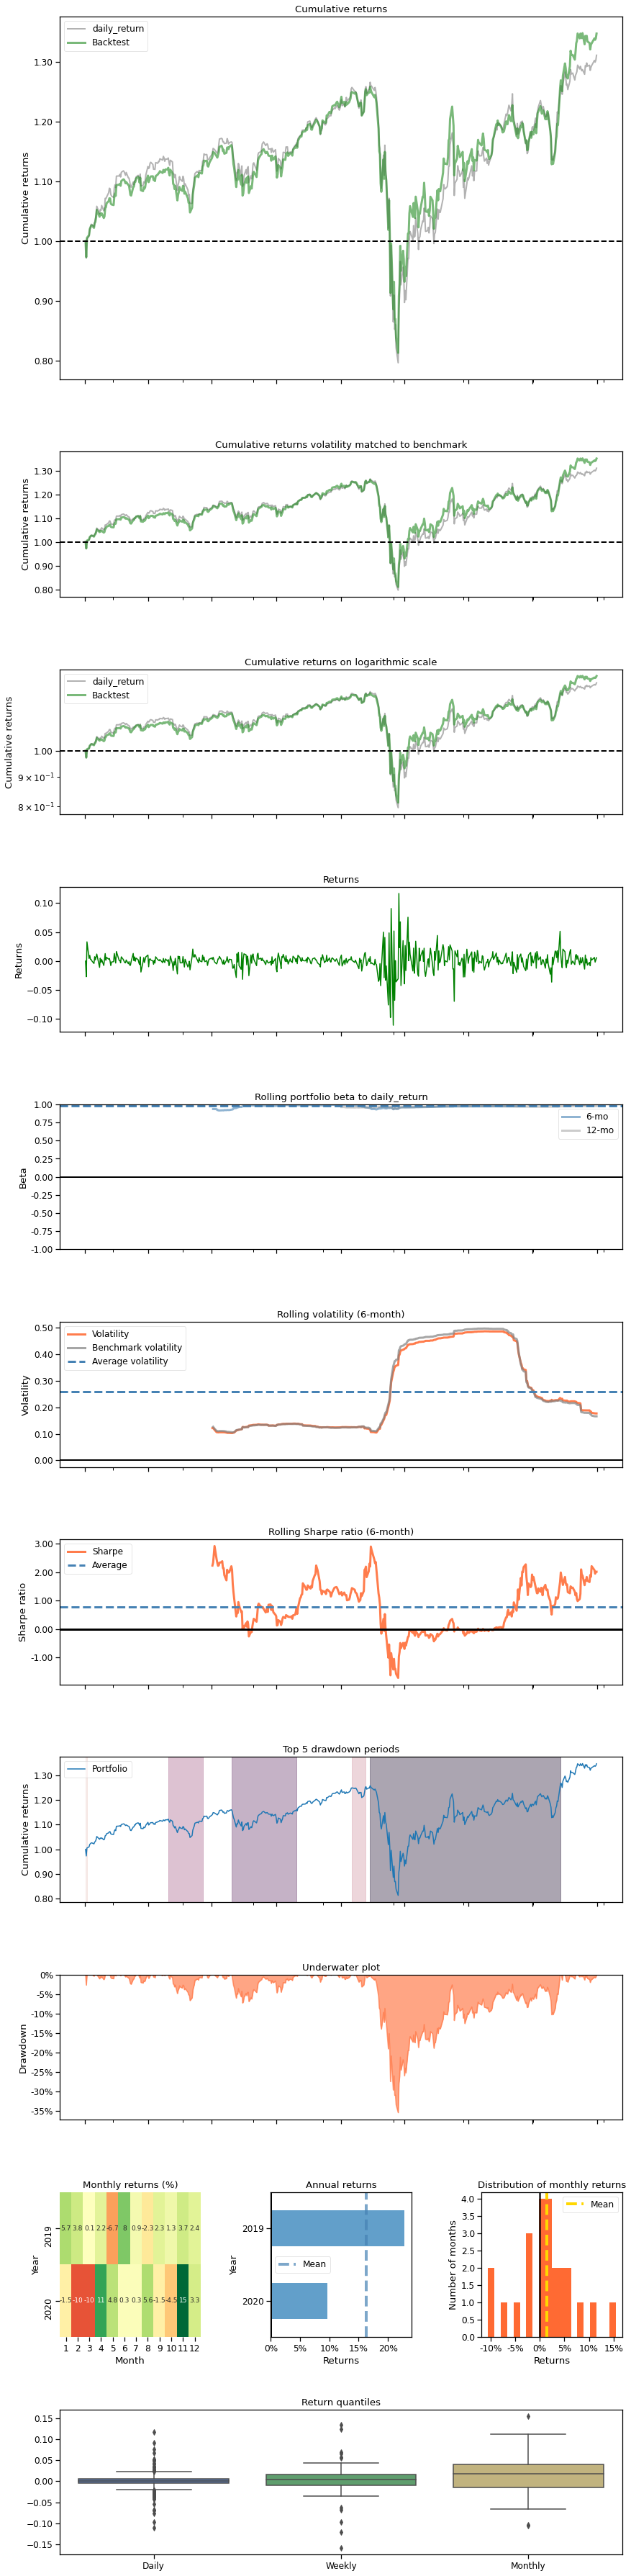

In [64]:
# plot
import pyfolio
%matplotlib inline

baseline_df = get_baseline(ticker='^DJI',
                           start='2019-01-01',
                           end='2021-01-01')

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns,
                                       set_context=False)